In [17]:
using NeuralPDE, Lux, Optimization, OptimizationOptimJL
import ModelingToolkit: Interval
using Plots, PlotThemes; theme(:dao)

In [15]:
@parameters x y t
@variables u(..)
Dxx = Differential(x)^2
Dyy = Differential(y)^2
Dt = Differential(t)

(::Differential) (generic function with 2 methods)

In [16]:
# 2D PDE
eq  = Dxx(u(x,y,t)) + Dyy(u(x,y,t)) ~ Dt(u(x,y,t))

Differential(x)(Differential(x)(u(x, y, t))) + Differential(y)(Differential(y)(u(x, y, t))) ~ Differential(t)(u(x, y, t))

In [31]:
xx = 0:0.01:1;

In [47]:
initialcond(x,y) = 1-tanh(100((x-0.5)^2 + (y-0.5)^2- 0.2^2))/2

initialcond (generic function with 1 method)

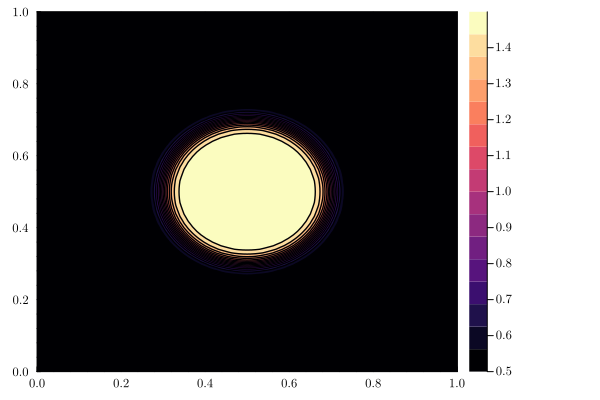

In [48]:
plot(xx, xx, [initialcond(x,y) for x in xx for y in xx], linetype=:contourf)

In [54]:
# Boundary conditions
bcs = [u(0,y,t) ~ 0.0, u(1,y,t) ~ 0.0,
       u(x,0,t) ~ 0.0, u(x,1,t) ~ 0.0,
       u(x,y,0) ~ initialcond(x,y)]
# Space and time domains
domains = [x ∈ Interval(0.0,1.0),
           y ∈ Interval(0.0,1.0),
           t ∈ Interval(0.0,10.0)]

3-element Vector{Symbolics.VarDomainPairing}:
 Symbolics.VarDomainPairing(x, 0.0..1.0)
 Symbolics.VarDomainPairing(y, 0.0..1.0)
 Symbolics.VarDomainPairing(t, 0.0..10.0)

In [55]:
# Neural network
dim = 3 # number of dimensions
chain = Lux.Chain(Dense(dim,16,Lux.tanh),Dense(16,16,Lux.tanh),Dense(16,1))

Chain(
    layer_1 = Dense(3 => 16, tanh_fast),  # 64 parameters
    layer_2 = Dense(16 => 16, tanh_fast),  # 272 parameters
    layer_3 = Dense(16 => 1),           # 17 parameters
)         # Total: 353 parameters,
          #        plus 0 states, summarysize 48 bytes.

In [56]:
# Discretization
dx = 0.05
discretization = PhysicsInformedNN(chain,GridTraining(dx))


PhysicsInformedNN{GridTraining{Float64}, Nothing, NeuralPDE.Phi{Chain{NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(identity), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}}}}, NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{NamedTuple{(), Tuple{}}, NamedTuple{(), Tuple{}}, NamedTuple{(), Tuple{}}}}}, typeof(NeuralPDE.numeric_derivative), Bool, Nothing, Nothing, Nothing, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}(Chain(), GridTraining{Float64}(0.05), nothing, NeuralPDE.Phi{Chain{NamedTuple{(:layer_1, :layer_2, :layer_3), Tuple{Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(NNlib.tanh_fast), typeof(Lux.glorot_uniform), typeof(Lux.zeros32)}, Dense{true, typeof(identity), typeof(Lux.glorot_uniform), typeof(Lux.zero

In [57]:
@named pde_system = PDESystem(eq,bcs,domains,[x,y,t],[u(x, y,t)])
prob = discretize(pde_system,discretization)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.4495585262775421 0.28629806637763977 -0.4224291145801544; 0.5474799275398254 -0.38025566935539246 0.023393118754029274; … ; -0.5582684874534607 -0.18923436105251312 -0.18625926971435547; -0.29378995299339294 -0.2354140728712082 -0.49465206265449524], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.11065098643302917 0.25835558772087097 … -0.3328193426132202 0.053113508969545364; 0.25341805815696716 0.08233515173196793 … -0.2914533019065857 -0.26465147733688354; … ; 0.26716259121894836 0.24028775095939636 … -0.38825517892837524 0.14616139233112335; -0.4010980725288391 0.1779315173625946 … -0.17447566986083984 0.37220802903175354], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.037949152290821075 -0.2669346332550049 … -0.02349737472832203 0.14116398990154266], bias = [0.0;;]))

In [59]:
#Optimizer
opt = OptimizationOptimJL.BFGS()

BFGS{LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Nothing, Nothing, Flat}(LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, nothing, Flat())

In [60]:
#Callback function
callback = function (p,l)
    println("Current loss is: $l")
    return false
end

#53 (generic function with 1 method)

In [61]:
res = Optimization.solve(prob, opt, callback = callback, maxiters=1000)
phi = discretization.phi

Current loss is: 1.8198978026042854
Current loss is: 1.5344060479568018
Current loss is: 0.28411778664726334
Current loss is: 0.23047606568584678
Current loss is: 0.18224821120025966
Current loss is: 0.16697815248629064
Current loss is: 0.15583484889188545
Current loss is: 0.14284445341320154
Current loss is: 0.13430630600985125
Current loss is: 0.12736822078113352
Current loss is: 0.12627089089440288
Current loss is: 0.1234956643896114
Current loss is: 0.12237458425323385
Current loss is: 0.12109245868222286
Current loss is: 0.12039880928133377
Current loss is: 0.11855633964019544
Current loss is: 0.11603108767260162
Current loss is: 0.11336460987537055
Current loss is: 0.1125396434349648
Current loss is: 0.11017728740566048
Current loss is: 0.10873969117665745
Current loss is: 0.10692257798128332
Current loss is: 0.10583447107974384
Current loss is: 0.10224612701526649
Current loss is: 0.10020347110810218
Current loss is: 0.09742949309878775
Current loss is: 0.0937678942144727
Curren

LoadError: InterruptException:

In [12]:
using Plots

xs,ys = [infimum(d.domain):dx/10:supremum(d.domain) for d in domains]
# analytic_sol_func(x,y) = (sin(pi*x)*sin(pi*y))/(2pi^2)

u_predict = reshape([first(phi([x,y],res.u)) for x in xs for y in ys],(length(xs),length(ys)))
# u_real = reshape([analytic_sol_func(x,y) for x in xs for y in ys], (length(xs),length(ys)))
# diff_u = abs.(u_predict .- u_real)

# p1 = plot(xs, ys, u_real, linetype=:contourf,title = "analytic");
p2 = plot(xs, ys, u_predict, linetype=:contourf,title = "predict");
# p3 = plot(xs, ys, diff_u,linetype=:contourf,title = "error");
# plot(p1,p2,p3)

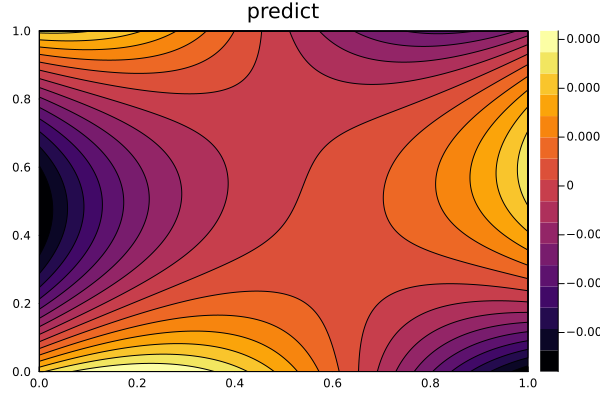

In [13]:
p2